# Uppgift 3 - Bildklassificering 

I denna uppgiften ska ni testa på att klassificera bilder mha 2 (3) olika tekniker:
* SVM - Support vector machines
* Fully-connected Neural Network (FC)
* Convolutional Neural Network (CNN)

Ni ska jämföra resultaten på test-setet utifrån bl.a. hur mycket data som användes för att träna de olika modellerna. Ni ska **kommentera koden** som ni skriver med korta förklaringar på vad koden gör.

Datasetet som ni kommer använda er av är ett subset av data från MNIST och innehåller handskrivna siffror från 0-9 i gråskala [0-255]. Datan är uppdelad i två filer, **train.csv** och **test.csv**, som finns tillsammans med uppgiften på Canvas.

Till er hjälp så är det meningen att ni ska använda er av följande paket:
* torch --- Huvudpaketet för ''pytorch'', används för att implementera och träna neurala nät.
* torchvision --- Stödpaket för ''pytorch'', används för att hantera data.
* sklearn --- Huvudpaketet för ''scikit-learn'', används för att implementera SVM:s.
* matplotlib --- Verktyg för att plotta grafer/bilder.
* pandas --- Verktyg för datahantering
* numpy --- Verktyg för datahantering/matris-manipulering

Paketen kan installeras på olika sätt, exempelvis genom Python-verktyget pip, och det kan då se ut såhär:

<pre><code> pip install torch </pre></code>

eller

<pre><code> pip3 install scikit-learn </pre></code>

Vi rekommenderar att ni gör detta i en virtuell Python-miljö via exempelvis Anaconda och med Python-version 3.8.*.

Paketen och klasserna som ska importeras är fördefinierade här under.

In [211]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.svm import SVC

### Uppgift 1 -  Ladda data

1. Ladda in datan från de två filerna med hjälp av **pandas** och spara i varsin DataFrame, train_df & test_df.
2. Dela upp träningsdatan i två delar, en för träning och en för validering, genom att specificera storleken på träningsdatan n_training_large. Skapa även en kopia av träningsdatan där endast de första 1000 datapunkterna ingår. Använd samma valideringsdata för alla modeller.
3. Ge en kort motivering till varför ni valt just detta värdet på **n_training_large**. 
4. Ta reda på vilken column i datan som innehåller svaret på vilken klass en bild tillhör och printa det.

In [212]:
# Uppgift 1.1

# Load the two files into dataframes using pandas and store 
train_df = pd.read_csv("train.csv") # CODE HERE
test_df = pd.read_csv("test.csv") 

In [213]:
# Uppgift 1.2

# Separate the data into a suitable split between training and validation
# by specifing the number of samples in the training set, n_training_data.
n_training_small = 1000
n_training_large = len(train_df) * 4//5


print('Training data - small: {}'.format(n_training_small))
print('Training data - large: {}'.format(n_training_large))
print('Validation data: {}'.format(len(train_df) - n_training_large))
print('Test data: {}'.format(len(test_df)))

Training data - small: 1000
Training data - large: 25598
Validation data: 6400
Test data: 10002


Ge en kort motivering till valet av storleken på **n_training_large**

In [214]:
# Uppgift 1.3
# ANSWER HERE
#It seems reasonable that the is training data is 80% of the data and validation on 20%

In [215]:
# This code separates the data into two parts according to the size of the training data, n_training_large & n_training_small,
# specified above.
val_df = train_df.iloc[n_training_large:, :].copy()
train_df_small = train_df.iloc[0:n_training_small, :].copy()
train_df = train_df.iloc[0:n_training_large, :].copy()

In [216]:
# Printing the shape of the data
print(train_df.shape)
print(train_df_small.shape)
print(val_df.shape)
print(test_df.shape)

(25598, 785)
(1000, 785)
(6400, 785)
(10002, 785)


In [217]:
# Uppgift 1.4

# Figure out which column that contains the labels (classes) and print it here
# CODE HERE

print(train_df.iloc[0:, 0])
print(train_df.iloc[0:, 1:])

0        1
1        0
2        1
3        4
4        0
        ..
25593    4
25594    4
25595    5
25596    2
25597    0
Name: label, Length: 25598, dtype: int64
       pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
25593       0       0       0       0       0       0       0       0       0   
25594       0       0       0       0       0       0       0       0       0   
25595       0       0       0       0       0       0       0       0       0   
25596       0       0       

### Uppgift 2 - Formatera data

Kod för att bearbeta data kan snabbt bli rörig och svår att underhålla och bör därför inte hänga ihop med koden som tränar nätverken. Detta ger också bättre läsbarhet och ökad modularitet. PyTorch tillhandahåller två hjälp-klasser: **torch.utils.data.DataLoader** och **torch.utils.data.Dataset** som låter dig ladda in färdiga dataset samt skapa egna. Klassen **Dataset** lagrar datapunkterna och deras motsvarande labels och **DataLoader** gör om datasetet till en *iterable* för att göra det enkelt att använda datapunkterna. I koden i blocket nedan så ser ni skelettet till ett egenskapat dataset, **MNISTDataset**, som ärver klassen **Dataset**. 


1. Gör klart implementationen av Dataset-klassen **MNISTDataset** genom att skriva kod som separerar datan i labels och features samt normaliserar datan och gör om den till matriser som motsvarar bilder av storleken 28x28 pixlar.
2. Skapa 4 dataset utifrån train_df, train_df_small, val_df och test_df.
3. Bestäm storlekarna på batcherna som ska användas vid träning respektive testning och skapa 4 DataLoaders för de fyra dataseten ovan. Träningsdatan ska slumpas men inte validering och test.
4. Plotta ett par exempelbilder och deras labels mha **matplotlib** och DataLoadern för träningssetet.

In [218]:
# Uppgift 2.1

class MNISTDataset(Dataset): 
  def __init__(self, df):
    # Separate the labels and the pixel values into the arrays y and x, respectively.
    # CODE HERE
    y = []
    x = []
    
    # Normalize the x-values and transform the data into images of size (color channels, width, height), i.e. w(1, 28, 28).
    # CODE HERE
    for index, row in df.iterrows():
      y.append(row["label"])
      pixel=row.loc[df.columns != "label"] 
      x.append(pixel.values.reshape((1,28,28)) / 255) 
 
    # the numpy arrays are converted into tensors that will be used in the training and testing of the network
    self.x=torch.tensor(x,dtype=torch.float32)
    self.y=torch.tensor(y)
 
  def __len__(self):
    # returns the number of samples in the dataset
    return len(self.y)
   
  def __getitem__(self, idx):
    # returns a sample from the dataset at the given index idx
    return self.x[idx], self.y[idx]

In [219]:
# Uppgift 2.2

# Create four datasets, from the dataframes defined earlier, using the MNISTDataset class
train_dataset = MNISTDataset(train_df)
train_dataset_small = MNISTDataset(train_df_small)
val_dataset = MNISTDataset(val_df)
test_dataset = MNISTDataset(test_df)

In [220]:
# Uppgift 2.3

# Specify the batch_sizes to use for training and testing
batch_size_train = 10
batch_size_test = 10

# Create four DataLoaders from the four datasets above. Shuffle the training data but not the others.
train_dload = DataLoader(train_dataset, batch_size=batch_size_train)
train_dload_small = DataLoader(train_dataset_small, batch_size=batch_size_train)
val_dload = DataLoader(val_dataset, batch_size=batch_size_train)
#test_dload = DataLoader(test_dataset, batch_size=batch_size_test)

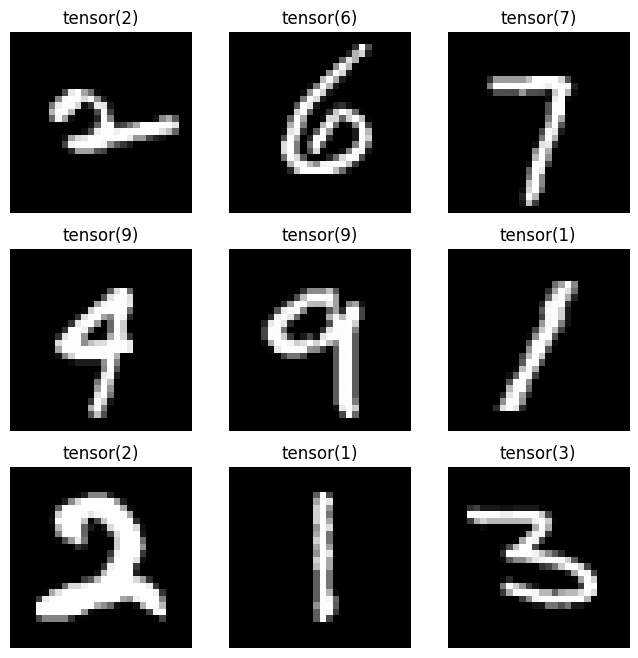

In [221]:
# Uppgift 2.4

# Plot images and labels for a few examples using the DataLoader for the training set.
# CODE HERE

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Uppgift 3 - Bygga dense-nätverk

Det första neurala nätverket vi ska skapa är ett så kallat Fully-connected/Dense Neural Network och består därför endast av lager där alla neuroner i ett lager är sammankopplade med alla neuroner från lagret innan. I **pytorch** så kan man skapa sin egen klass för ett nätverk genom att ärva *nn.Module* och implementera en *__ init__()* samt en *forward()* metod.

Ett lager av typen FC skapas i **pytorch** med hjälp av *nn.Linear* enligt exemplet nedan. 
<pre><code> nn.Linear(nr_of_input_neurons, nr_of_output_neurons) </pre></code>
De viktigaste input-parametrarna är antalet neuroner i lagret innan, **nr_of_input_neurons**, samt hur många neuroner detta lagret ska ha, **nr_of_output_neurons**. Mer information hittar ni i dokumentationen: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

I dokumentationen hittar ni också information om olika aktiveringsfunktioner: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

När nätverket är färdigt så är nästa steg att bestämma sin loss-funktion samt learning rate och optimerare.

1. Gör klart nätverket.
2. Välj loss-funktion, learning rate och optimizers.

In [222]:
# Uppgift 3.1

class DenseNet(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super().__init__()

        # Add more Linear (FC/Dense) layers here and experiment with different number of neurons.
        self.fc_in = nn.Linear(input_size, 500)
        self.fc_between = nn.Linear(500, 100)
        self.fc_between2 = nn.Linear(100, 8)
        self.fc_out = nn.Linear(self.fc_between2.out_features, num_classes)

        self.activation = nn.ReLU()

    def forward(self, x):
        # Reshapes the input of size (batch x 1x28x28) into a vector (batch x784)
        x = x.view(x.shape[0], -1)

        x = self.fc_in(x)
        x = self.activation(x)

        x = self.fc_between(x)
        x = self.activation(x)

        x = self.fc_between2(x)
        x = self.activation(x)

        x = self.fc_out(x)

        return x

In [223]:
# Create the network
dense_net = DenseNet()

# Printing the network gives an overview of the network structure
print(dense_net)
# and calculating the nuber of parameters gives the size of the network
print('Number of parameters: {}'.format(sum([param.nelement() for param in dense_net.parameters()])))


DenseNet(
  (fc_in): Linear(in_features=784, out_features=500, bias=True)
  (fc_between): Linear(in_features=500, out_features=100, bias=True)
  (fc_between2): Linear(in_features=100, out_features=8, bias=True)
  (fc_out): Linear(in_features=8, out_features=10, bias=True)
  (activation): ReLU()
)
Number of parameters: 443498


Bestäm en learning rate, vilken loss-funktion samt vilken optimerare som ska användas för att lösa uppgiften.

Loss-funktioner hittar man i modulen **nn** på följande sätt: 

<pre><code> nn.NamnetPåLossFunktionen() </pre></code>

där de olika varianterna hittas här https://pytorch.org/docs/stable/nn.html#loss-functions

och optimerare:

<pre><code> optim.NamnetPåOptimeraren() </pre></code>

som hittas här https://pytorch.org/docs/stable/optim.html

In [224]:
# Uppgift 3.2

learning_rate = 0.1

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(dense_net.parameters(), lr=learning_rate)

### Uppgift 4 - Träna och evaluera dense-nätverk

Träning av nätverket innebär att vi i epoker (upprepade omgångar) låter nätverket gissa klassen på samtliga våra bilder i träningsdatan. Felet och dess gradienterna för samtliga parametrar beräknas mha loss-funktionen och nätverket uppdateras sen utifrån gradienterna av optimeraren.

1. Skriv en funktion *train(network, epoch, dataset)* som tar emot nätverket, numret på en epok samt träningsdata och utför träning av nätverket i batcher tills all data har gåtts igenom en gång. Beräkna gradienterna och uppdatera värdet.
2. Skriv en funktion *test(dataset)* som beräknar average loss och accuracy för nätverket på ett angivet dataset och sedan printar detta. Funktionen ska returnera snitt-felet som ett värde.
3. Experimentera er fram till ett nätverk som presterar bra (>96% accuracy) på det stora träningssetet och jämför sedan resultatet med en kopia av samma nätverk som man tränar om med det lilla datasetet.

Nedan följer en beskrivning i text av vad *train* ska göra:

<pre><code> 
funktion train(network, epoch, dataset)
    Sätt nätverket i träningsläge
    För varje batch i datasetet
        Nollställ optimerarens gradienter    
        Beräkna nätverkets gissningar utifrån batchen med data
        Beräkna felet mha loss-funktionen och true-labels/targets
        Beräkna fel-gradienterna för samtliga parametrar
        Uppdatera nätverket mha optimeraren
        
        För vissa batcher, printa info om hur träningen går, exempelvis batch, loss och procent av epoken som är klar.
</pre></code>

In [225]:
# Uppgift 4.1

def train(network, epoch, dataset):
    network.train()
    for i,(train_features,train_labels) in enumerate(dataset):
        optimizer.zero_grad()
        output = network(train_features)
        loss = loss_function(output, train_labels)
        loss.backward()
        optimizer.step()

Nedan följer en beskrivning i text av vad *test* ska göra:

<pre><code> 
funktion test(network, dataset)
    y_true = []
    y_pred = []
    
    Sätt nätverket i evalueringsläge
    Stäng av användningen av gradienter
        För varje batch i datasetet
            Beräkna nätverkets gissningar utifrån batchen med data
            Beräkna felet mha loss-funktionen och true-labels/targets
            Spara gissningarna i y_pred
            Spara de rätta svaren i y_true
            
    Använd y_pred och y_true för att beräkna accuracy och skapa en confusion matrix
    Printa Avg. loss, accuracy och en confusion matrix
    Returnera Avg. loss
</pre></code>

In [226]:
# Uppgift 4.2

def test(network, dataset):
    y_true = []
    y_pred = []
    losses = []
    network.eval()
    with torch.no_grad():
        for i,(features,labels) in enumerate(dataset):
            output = network(features)
            loss = loss_function(output, labels)
            y_pred.append(output)
            y_true.append(labels)
            losses.append(loss)
    #print(f"Batch = {i}, loss = {loss}, epoch = {epoch}")
    avg_loss = np.mean(losses)
    TP = 0
    for i in range(len(y_true)):
        true = y_true[i]
        pred = y_pred[i]
        _, indices = torch.max(pred, 1)
        #print(true, pred)
        match=True
        for j in range(len(true)):
            if true[j]== indices[j]:
                TP+=1
        
    accuracy = TP/(len(y_true)*len(y_true[0]))
    print(f"Avg. Loss = {avg_loss}, Accuracy = {accuracy}")
    
    
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import itertools as it
    y_true_list=[]
    y_pred_list=[]
    #print(y_pred)
    #print(y_true)
    for yt, yp in zip (y_true, y_pred):
        for j in range(len(yp)):
            y_true_list.append(yt[j].item())
            _,x = torch.max(yp,1)
            y_pred_list.append(x[j].item())
    #print(y_pred_list)
    cm = confusion_matrix(y_true_list, y_pred_list)
    

        
     
    return avg_loss, cm
    #raise NotImplementedError('Function not implemented yet.')

Det som är kvar nu är att träna nätverket i flera omgångar (epoker) och kontinuerligt utvärdera hur träningen går mha valideringsdatan. Varje gång en ny lägsta (bästa) loss uppnås så kan modellen och optimeraren sparas för att användas igen senare.

In [227]:
def run(net_filename,opti_filename,network_to_train, data_to_train):
    n_epochs = 10
    #net_filename = net_filename
    #opti_filename = opti_filename
    best_loss = 10 ** 4

    for epoch in range(1, n_epochs + 1):
        # Perform training once on the entire set of training data
        train(network_to_train, epoch, data_to_train)  

        # Evaluate the net using validation data
        val_loss,_ = test(network_to_train, val_dload)

        # If the latest training yielded a lower validation loss than ever before, save the model to file such that the best one
        # can always be retrieved afterwards. 
        if val_loss < best_loss:
            print('Saving best model to {}\n'.format('./results/{}.pth'.format(net_filename)))

            # Save the network
            torch.save(network_to_train.state_dict(), './results/{}.pth'.format(net_filename))
            # Save the optimizer, in case we want to continue training later
            torch.save(optimizer.state_dict(), './results/{}.pth'.format(opti_filename))
            # Update the best loss to the current loss
            best_loss = val_loss
run("net.txt", "opti.txt", dense_net, train_dload)

Avg. Loss = 0.33135831356048584, Accuracy = 0.9009375
Saving best model to ./results/net.txt.pth

Avg. Loss = 0.17672301828861237, Accuracy = 0.948125
Saving best model to ./results/net.txt.pth

Avg. Loss = 0.1613035649061203, Accuracy = 0.9540625
Saving best model to ./results/net.txt.pth

Avg. Loss = 0.13585279881954193, Accuracy = 0.9646875
Saving best model to ./results/net.txt.pth

Avg. Loss = 0.12631629407405853, Accuracy = 0.96796875
Saving best model to ./results/net.txt.pth

Avg. Loss = 0.13736072182655334, Accuracy = 0.96546875
Avg. Loss = 0.14844700694084167, Accuracy = 0.96453125
Avg. Loss = 0.15189030766487122, Accuracy = 0.96734375
Avg. Loss = 0.15085645020008087, Accuracy = 0.96828125
Avg. Loss = 0.15266746282577515, Accuracy = 0.965625


Ett sparat nätverk kan sedan laddas in med *torch.load(filename)* enligt koden nedan.

In [228]:
dense_net = DenseNet()
net_filename = "net.txt"

network_state_dict = torch.load('./results/{}.pth'.format(net_filename))
dense_net.load_state_dict(network_state_dict)

<All keys matched successfully>

##### Uppgift 4.3
Experimentera er fram till ett nätverk som presterar bra (>96% accuracy) på det stora träningssetet genom att uppdatera och ändra nätverket i uppgift 3.1

Jämför sedan resultatet med en kopia av samma nätverk som man tränar om med det lilla datasetet. Printa båda nätverkens accuracy och deras respektive confusion matrix.

Avg. Loss = 0.12631629407405853, Accuracy = 0.96796875


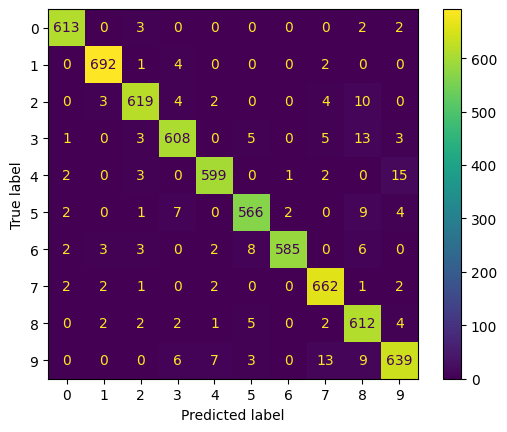

In [229]:
# CODE HERE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test1, cm = test(dense_net, val_dload)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Avg. Loss = 1.8716083765029907, Accuracy = 0.3346875
Saving best model to ./results/net_small.txt.pth

Avg. Loss = 0.945052444934845, Accuracy = 0.72046875
Saving best model to ./results/net_small.txt.pth

Avg. Loss = 0.7068090438842773, Accuracy = 0.78203125
Saving best model to ./results/net_small.txt.pth

Avg. Loss = 0.5658890008926392, Accuracy = 0.831875
Saving best model to ./results/net_small.txt.pth

Avg. Loss = 0.5267763137817383, Accuracy = 0.850625
Saving best model to ./results/net_small.txt.pth

Avg. Loss = 0.7005313634872437, Accuracy = 0.81046875
Avg. Loss = 0.4993573725223541, Accuracy = 0.86796875
Saving best model to ./results/net_small.txt.pth

Avg. Loss = 0.5417184829711914, Accuracy = 0.8678125
Avg. Loss = 0.5405210256576538, Accuracy = 0.87296875
Avg. Loss = 0.7300411462783813, Accuracy = 0.84640625
Avg. Loss = 0.7300411462783813, Accuracy = 0.84640625


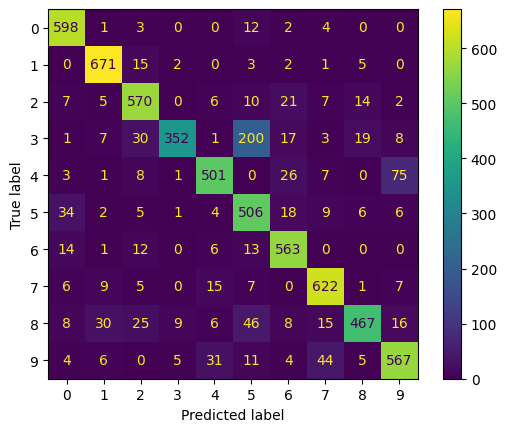

In [230]:
#some extra code
dense_net_small = DenseNet()
optimizer = optim.SGD(dense_net_small.parameters(), lr= learning_rate)


run("net_small.txt", "opti_small.txt", dense_net_small, train_dload_small)

testsmall, cm2 = test(dense_net_small, val_dload)

disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()
plt.show()


### Uppgift 5 - Träna och evaluera SVM:s

1. När vi tränar SVM:s mha scikit-learn så kan vi inte längre använda oss av våra DataLoaders utan behöver därför gå tillbaka till våra dataframes, train_df, train_df_small, val_df och test_df. Skriv kod som separerar varje dataframe i features (pixlar) och labels (klasser) samt normaliserar features [0, 1].
2. Skriv kod för att med hjälp av sklearn och klassen SVC skapa en SVM-modell för bildklassificering.
3. Träna SVM-modellen på träningsdatan.
4. Experimentera er fram till en SVM-modell som presterar bra (>95% accuracy) på det stora träningssetet och jämför sedan resultatet med en kopia av samma nätverk som man tränar om med det lilla datasetet.

In [231]:
# Uppgift 5.1


def format(df):
    y = []
    x = []
    for index,row in df.iterrows():
        y.append(row["label"])
        pixels=row.loc[df.columns != "label"]
        x.append(pixels.values / 255)
    return y, x
train_y ,train_X = format(train_df)

train_y_small ,train_X_small = format(train_df_small)

val_y, val_X = format(val_df)

test_y, test_X = format(test_df)

In [232]:
# Uppgift 5.2
# CODE HERE
from sklearn import svm
svm_model = svm.SVC()

In [233]:
# Uppgift 5.3
# CODE HERE
svm_model.fit(train_X, train_y)

SVC()

In [234]:
def evaluate_svm_model(model, testX, testy):
    # Make predictions
    y_pred = model.predict(testX)
    
    # Calculate accuracy
    acc = metrics.accuracy_score(y_true=testy, y_pred=y_pred)
    # Create confusion matrix
    cm = metrics.confusion_matrix(testy, y_pred)

    print("Accuracy:", round(acc, 4) * 100, "\n")
    print(cm)

In [235]:
evaluate_svm_model(svm_model, val_X, val_y)

Accuracy: 97.19 

[[616   0   2   0   0   1   0   0   0   1]
 [  0 689   4   2   1   0   0   2   0   1]
 [  2   2 623   1   2   1   1   5   5   0]
 [  2   0   5 616   0   7   0   3   2   3]
 [  2   0   2   0 605   0   1   0   0  12]
 [  0   0   2   3   2 577   4   1   0   2]
 [  5   1   0   0   2   3 596   0   2   0]
 [  1   2   2   0   4   0   0 654   0   9]
 [  0   4   3   4   3   6   2   2 603   3]
 [  0   1   2  10   9   1   0   9   4 641]]


##### Uppgift 5.4
Experimentera er fram till en SVM-modell som presterar bra (>95% accuracy) på det stora träningssetet genom att uppdatera och ändra modellen i Uppgift 5.2.

Jämför sedan resultatet med en kopia av samma modell som man tränar om med det lilla datasetet. Printa båda modellernas accuracy och deras respektive confusion matrix.

In [236]:
#Some extra code
dense_net = DenseNet()
net_filename = "net.txt"


network_state_dict = torch.load('./results/{}.pth'.format(net_filename))
dense_net.load_state_dict(network_state_dict)

<All keys matched successfully>

In [237]:
# CODE HERE
svm_model_small = svm.SVC()
svm_model_small.fit(train_X_small,train_y_small)
evaluate_svm_model(svm_model_small, val_X, val_y)

Accuracy: 92.09 

[[603   0   6   0   1   3   4   1   2   0]
 [  0 681   5   1   1   6   2   0   1   2]
 [  2   6 599   6   5   1   8   4  11   0]
 [  1   2  14 562   0  20   4  10  18   7]
 [  2   5   3   0 560   0   2   1   3  46]
 [  1   4   4   6   7 543  11   2   7   6]
 [  5   1   7   0   8   6 579   0   3   0]
 [  6   5  10   0  11   2   0 619   2  17]
 [  2  13  10  17   3  16   2   5 553   9]
 [  2   4  11  13  25   1   0  16  10 595]]


### Uppgift 6 - Träna och evaluera CNN

Den sista delen av den här inlämningen är att ni ska implementera och utvärdera ett CNN utifrån de verktyg ni har använt tidigare under uppgiften. En viktig skillnad med convolutions jämfört med FC-lager är att de gradvis minskar storleken på sin output utifrån kernel-size:n (n, m) och att antalet kanaler/channels motsvarar antalet filter i lagret. Exempelvis så kommer en input på 28x28 som körs genom en convolution med kernel-size (3, 4) och stride=1 ge en output som är (28-n+1)x(28-m+1)=26x25. Använder man däremot padding när man genomför sina convolutions så blir input och output lika stora.

I pytorch genomför man convolutions mha:
<pre><code> nn.Conv2d(nr_of_input_filters, nr_of_output_filters, kernel) </pre></code>

För mer information se dokumentationen: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

1. Gör klart implementationen av ett CNN
2. Experimentera fram ett CNN-nätverk som presterar minst lika bra som Dense-nätet.
3. Jämför sedan resultatet med en kopia av samma modell som man tränar om med det lilla datasetet. Printa båda modellernas accuracy och deras respektive confusion matrix.

In [238]:
class ConvModel(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.kernel = 5
        self.filters = 6
        
        self.conv_in = nn.Conv2d(input_channels, self.filters, self.kernel)
        self.conv_b = nn.Conv2d(6, 16, self.kernel)
        
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.activation = nn.ReLU()
        
        self.fc = nn.Linear(256, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(self.activation(self.conv_in(x)))
        x = self.pool(self.activation(self.conv_b(x)))
        x = torch.flatten(x, 1)
        
        x = self.fc(x)
        x = self.log_softmax(x)

        return x

In [239]:
conv_net = ConvModel()
print(conv_net)

ConvModel(
  (conv_in): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv_b): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
  (fc): Linear(in_features=256, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


Avg. Loss = 0.09937374293804169, Accuracy = 0.9684375
Saving best model to ./results/conv_net.txt.pth

Avg. Loss = 0.08099506050348282, Accuracy = 0.97546875
Saving best model to ./results/conv_net.txt.pth

Avg. Loss = 0.07418584823608398, Accuracy = 0.97921875
Saving best model to ./results/conv_net.txt.pth

Avg. Loss = 0.07028381526470184, Accuracy = 0.980625
Saving best model to ./results/conv_net.txt.pth

Avg. Loss = 0.08062504976987839, Accuracy = 0.978125
Avg. Loss = 0.08936440944671631, Accuracy = 0.974375
Avg. Loss = 0.08375607430934906, Accuracy = 0.97734375
Avg. Loss = 0.08825158327817917, Accuracy = 0.9771875
Avg. Loss = 0.09661348909139633, Accuracy = 0.9759375
Avg. Loss = 0.11195801198482513, Accuracy = 0.97375
Avg. Loss = 0.11195801198482513, Accuracy = 0.97375


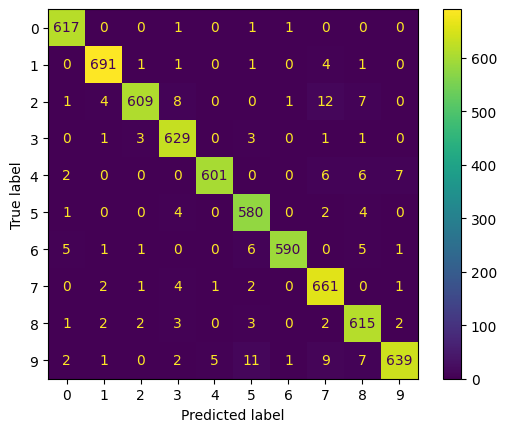

In [240]:
# Uppgift 6.2
# CODE HERE
conv_net = ConvModel()
optimizer = optim.SGD(conv_net.parameters(), lr= learning_rate)
loss_function = nn.CrossEntropyLoss()
net_filename = "conv_net.txt"

run("conv_net.txt", "opti_conv.txt", conv_net, train_dload)

testconv, cm2 = test(conv_net, val_dload)

disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()
plt.show()

### Uppgift 7 - Jämför restultaten på test-setet

Gör en jämförelse av de tre sätten att klassificera på utifrån de resultat ni har fått på test-setet, både för det stora och det lilla setet med träningsdata. Komplettera er jämförelse med grafer, resultat, kod eller annat som stärker er argumentation i första rutan nedan och skriv en kort beskrivning av era slutsatser i rutan under det.

net.txt
Avg. Loss = 0.12631629407405853, Accuracy = 0.96796875


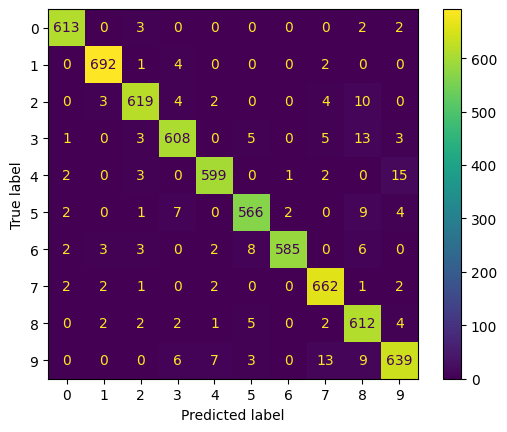

net_small.txt
Avg. Loss = 0.4993573725223541, Accuracy = 0.86796875


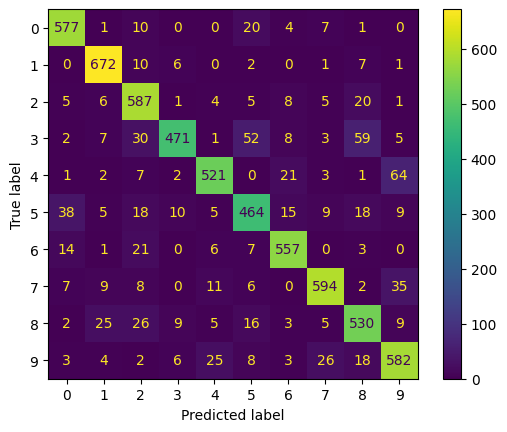

conv_net.txt
Avg. Loss = 0.07028381526470184, Accuracy = 0.980625


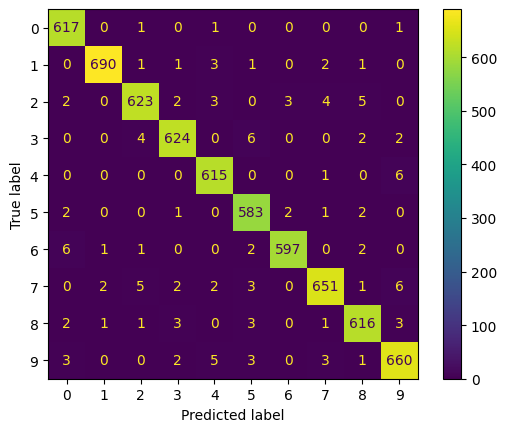

SVM
Accuracy: 97.19 

[[616   0   2   0   0   1   0   0   0   1]
 [  0 689   4   2   1   0   0   2   0   1]
 [  2   2 623   1   2   1   1   5   5   0]
 [  2   0   5 616   0   7   0   3   2   3]
 [  2   0   2   0 605   0   1   0   0  12]
 [  0   0   2   3   2 577   4   1   0   2]
 [  5   1   0   0   2   3 596   0   2   0]
 [  1   2   2   0   4   0   0 654   0   9]
 [  0   4   3   4   3   6   2   2 603   3]
 [  0   1   2  10   9   1   0   9   4 641]]
SVM-Small
Accuracy: 92.09 

[[603   0   6   0   1   3   4   1   2   0]
 [  0 681   5   1   1   6   2   0   1   2]
 [  2   6 599   6   5   1   8   4  11   0]
 [  1   2  14 562   0  20   4  10  18   7]
 [  2   5   3   0 560   0   2   1   3  46]
 [  1   4   4   6   7 543  11   2   7   6]
 [  5   1   7   0   8   6 579   0   3   0]
 [  6   5  10   0  11   2   0 619   2  17]
 [  2  13  10  17   3  16   2   5 553   9]
 [  2   4  11  13  25   1   0  16  10 595]]


In [241]:
# CODE HERE
filenames = ["net.txt","net_small.txt", "conv_net.txt"]
types = [DenseNet(),DenseNet(),ConvModel()]
for i,net in zip(filenames,types):
    
    network_state_dict = torch.load('./results/{}.pth'.format(i))
    net.load_state_dict(network_state_dict)
    print(i)
    testsmall, cm2 = test(net, val_dload)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
    disp.plot()
    plt.show()
print("SVM")
evaluate_svm_model(svm_model, val_X, val_y)

print("SVM-Small")
evaluate_svm_model(svm_model_small, val_X, val_y)

In [242]:
# TEXT HERE
#Baserat på accuracy-siffrorna i figuren ovan ser vi att Convolutional presterar bäst sen SVM och sist dense.
#För de små dataseten blir resultatet markant sämre.
#Slutsatsen är att det är viktigt med mycket data, viktare än klassificeringssätt.

### Uppgift 8 - Ungefär hur många timmar har gruppen lagt på att göra klart inlämningen

In [243]:
# TEXT HERE
# 15-20 timmar var